In [1]:
!rm -r data
!mkdir -p data

rm: cannot remove 'data': No such file or directory


In [2]:
!unzip -q data.zip -d temp

!mv temp/data/* ./data/
!rm -r temp

In [3]:
!pip install -q pandas numpy matplotlib scikit-learn tensorflow

# Analysing and feature extraction

In [4]:
import pandas as pd
import numpy as np
import re
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt


In [5]:
def load_csv(path, verbose=True):
    """
    Loads CSV with ISO timestamps like 2025-10-13T12:13:21.
    Ensures 'timestamp' column is parsed and placed at index 0.
    """
    df = pd.read_csv(path)

    # Parse first column as timestamp
    ts_raw = df.iloc[:, 0]
    df['timestamp'] = pd.to_datetime(ts_raw, errors='raise')

    # Remove old first column and move parsed timestamp to front
    df = df.drop(columns=[df.columns[0]])
    df.insert(0, 'timestamp', pd.to_datetime(ts_raw))

    if verbose:
        print(f"[load_csv] Loaded {path}")
        print(f"[load_csv] Shape: {df.shape}")
        print(f"[load_csv] Timestamp range: {df['timestamp'].min()} → {df['timestamp'].max()}")
        print(f"[load_csv] Columns: {list(df.columns)[:12]} ...")

    return df


[load_csv] Loaded data/case01_c1_L_moving.csv
[load_csv] Shape: (100, 68)
[load_csv] Timestamp range: 2025-10-13 12:20:23 → 2025-10-13 12:22:26
[load_csv] Columns: ['timestamp', 'mx_uT', 'my_uT', 'mz_uT', 'd0_mm', 'd1_mm', 'd2_mm', 'd3_mm', 'd4_mm', 'd5_mm', 'd6_mm', 'd7_mm'] ...


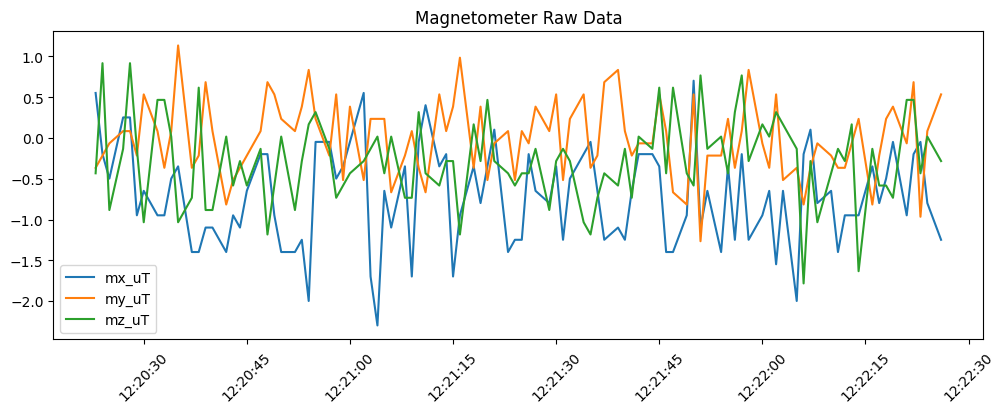

In [6]:
# SAMPLE TEST FOR load_csv
df_test = load_csv("data/case01_c1_L_moving.csv")

# Quick visualization of magnetometer to ensure timestamps + mag are correct
mag_cols = [c for c in df_test.columns if c.startswith(("mx","my","mz"))]

plt.figure(figsize=(12,4))
for c in mag_cols:
    plt.plot(df_test['timestamp'], df_test[c], label=c)
plt.legend()
plt.title("Magnetometer Raw Data")
plt.xticks(rotation=45)
plt.show()


In [7]:
def find_tof_cols(df, verbose=True):
    """
    Detects TOF columns of the form d<number>_mm (e.g., d0_mm, d32_mm).
    """
    tof_cols = [c for c in df.columns if re.fullmatch(r"d\d+_mm", c)]
    # sort by numeric part
    tof_cols = sorted(tof_cols, key=lambda x: int(re.search(r"\d+", x).group()))

    if verbose:
        print(f"[find_tof_cols] Found {len(tof_cols)} TOF channels.")
        print(f"[find_tof_cols] First few: {tof_cols[:10]}")

    return tof_cols


[find_tof_cols] Found 64 TOF channels.
[find_tof_cols] First few: ['d0_mm', 'd1_mm', 'd2_mm', 'd3_mm', 'd4_mm', 'd5_mm', 'd6_mm', 'd7_mm', 'd8_mm', 'd9_mm']


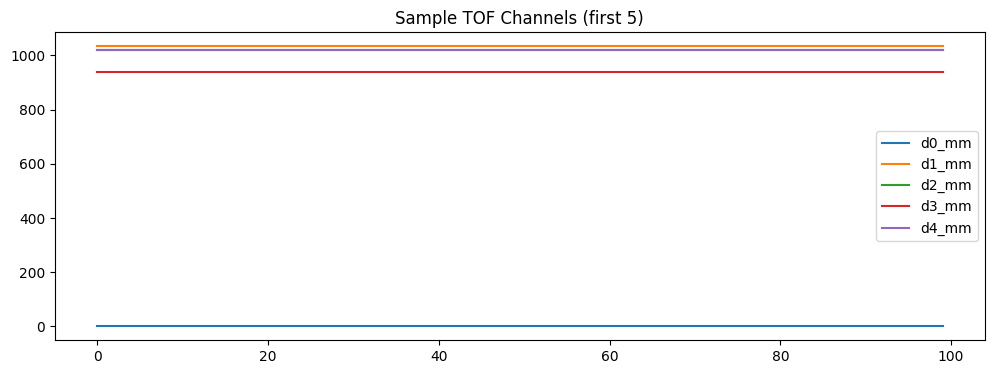

In [8]:
# SAMPLE TEST FOR find_tof_cols
tof_cols_test = find_tof_cols(df_test)

# Visualize the first 5 TOF channels to confirm data shape
plt.figure(figsize=(12,4))
for c in tof_cols_test[:5]:
    plt.plot(df_test[c].values, label=c)
plt.legend()
plt.title("Sample TOF Channels (first 5)")
plt.show()

In [9]:
def cluster_tof_channels(df, tof_cols, n_clusters=3, verbose=True):
    """
    Clusters TOF channels based on similarity across time.
    Returns groups ordered left → mid → right.
    """

    if len(tof_cols) == 0:
        raise ValueError("No TOF columns found to cluster.")

    # Matrix: (num_channels x num_timesteps)
    X = df[tof_cols].T.values
    stds = X.std(axis=1)

    # Normalize channels
    Xn = (X - X.mean(axis=1, keepdims=True)) / (stds[:, None] + 1e-9)

    # Ensure number of clusters <= number of channels
    n_clusters = min(n_clusters, len(tof_cols))

    cl = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    labels = cl.fit_predict(Xn)

    # Group channels by label
    groups = {}
    for i, lab in enumerate(labels):
        groups.setdefault(lab, []).append(tof_cols[i])

    # ---- FIX: extract NUMERIC part safely for d<number>_mm ----
    def sensor_index(name):
        # extracts digits inside the column name
        # e.g. d22_mm -> 22
        return int(re.search(r"\d+", name).group())

    # Sort groups by their mean numeric index (left→mid→right)
    ordered = sorted(groups.values(),
                     key=lambda g: np.mean([sensor_index(c) for c in g]))

    if verbose:
        print(f"[cluster_tof_channels] Created {len(ordered)} groups:")
        for i, g in enumerate(ordered):
            idxs = [sensor_index(c) for c in g]
            print(f"  Group {i}: size={len(g)}, mean index={np.mean(idxs):.2f}, sample={g[:6]}")

    return ordered


[cluster_tof_channels] Created 3 groups:
  Group 0: size=62, mean index=30.69, sample=['d0_mm', 'd1_mm', 'd2_mm', 'd3_mm', 'd4_mm', 'd5_mm']
  Group 1: size=1, mean index=56.00, sample=['d56_mm']
  Group 2: size=1, mean index=57.00, sample=['d57_mm']


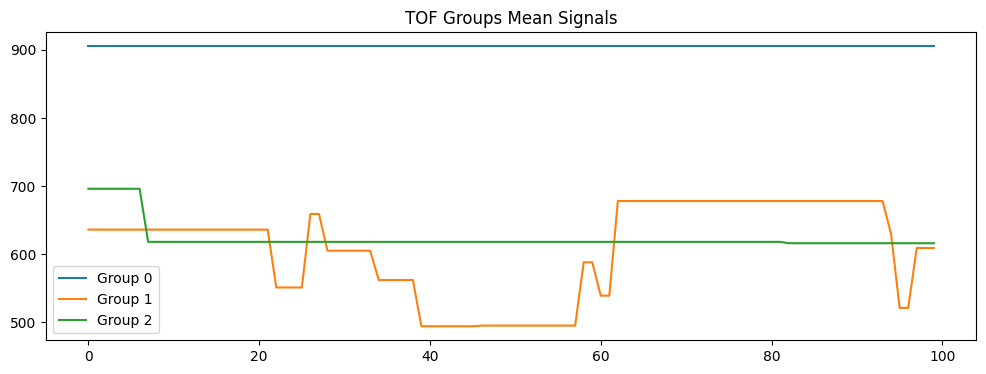

In [10]:
tof_groups_test = cluster_tof_channels(df_test, tof_cols_test)

plt.figure(figsize=(12,4))
for i, g in enumerate(tof_groups_test):
    plt.plot(df_test[g].mean(axis=1).values, label=f"Group {i}")
plt.legend()
plt.title("TOF Groups Mean Signals")
plt.show()


In [11]:
def extract_features(df, tof_cols, tof_groups, verbose=True):
    """
    Extracts features from magnetometer + TOF grouped channels.
    Returns a clean dataframe with engineered features.
    """
    out = pd.DataFrame()
    out['timestamp'] = df['timestamp']

    # -------- MAGNETOMETER FEATURES --------
    # exact names: mx_uT, my_uT, mz_uT
    mag_cols = [c for c in df.columns if c.lower().startswith(('mx', 'my', 'mz'))]

    if len(mag_cols) >= 3:
        # sort to get consistent x,y,z ordering
        mag_cols = sorted(mag_cols)
        out['mag_x'] = df[mag_cols[0]]
        out['mag_y'] = df[mag_cols[1]]
        out['mag_z'] = df[mag_cols[2]]
        out['mag_norm'] = np.sqrt(out['mag_x']**2 + out['mag_y']**2 + out['mag_z']**2)
    else:
        if verbose:
            print("[extract_features] WARNING: Magnetometer columns missing. Using mag_norm=0.")
        out['mag_norm'] = 0

    # -------- TOF GROUP FEATURES --------
    if verbose:
        print(f"[extract_features] Extracting TOF features from {len(tof_cols)} channels...")

    # for each of g0, g1, g2
    for i, grp in enumerate(tof_groups):
        grp_name = f"g{i}"

        if len(grp) == 0:
            if verbose:
                print(f"[extract_features] WARNING: Group {grp_name} is EMPTY.")
            # Fill zeros if group empty
            out[f"{grp_name}_min"] = 0
            out[f"{grp_name}_mean"] = 0
            out[f"{grp_name}_std"] = 0
            out[f"{grp_name}_med"] = 0
            out[f"{grp_name}_rel_min"] = 0
            continue

        # Extract group values
        sub = df[grp]

        out[f"{grp_name}_min"] = sub.min(axis=1)
        out[f"{grp_name}_mean"] = sub.mean(axis=1)
        out[f"{grp_name}_std"] = sub.std(axis=1)
        out[f"{grp_name}_med"] = sub.median(axis=1)
        out[f"{grp_name}_rel_min"] = out[f"{grp_name}_min"] - df[tof_cols].min(axis=1)

        if verbose:
            print(f"[extract_features] Group {grp_name}: {len(grp)} sensors → min={out[f'{grp_name}_min'].iloc[0]}")

    # -------- GLOBAL TOF FEATURES --------
    out["tof_min_all"] = df[tof_cols].min(axis=1)
    out["tof_mean_all"] = df[tof_cols].mean(axis=1)
    out["tof_std_all"] = df[tof_cols].std(axis=1)

    # -------- TEMPORAL DIFFERENCES --------
    for col in ["mag_norm", "tof_mean_all"]:
        out[f"{col}_diff"] = out[col].diff().fillna(0)

    if verbose:
        print("[extract_features] DONE extracting features.")
        print("[extract_features] Final feature columns:")
        print(out.columns.tolist())

    return out


[extract_features] Extracting TOF features from 64 channels...
[extract_features] Group g0: 62 sensors → min=0
[extract_features] Group g1: 1 sensors → min=636
[extract_features] Group g2: 1 sensors → min=696
[extract_features] DONE extracting features.
[extract_features] Final feature columns:
['timestamp', 'mag_x', 'mag_y', 'mag_z', 'mag_norm', 'g0_min', 'g0_mean', 'g0_std', 'g0_med', 'g0_rel_min', 'g1_min', 'g1_mean', 'g1_std', 'g1_med', 'g1_rel_min', 'g2_min', 'g2_mean', 'g2_std', 'g2_med', 'g2_rel_min', 'tof_min_all', 'tof_mean_all', 'tof_std_all', 'mag_norm_diff', 'tof_mean_all_diff']
            timestamp   mag_x   mag_y   mag_z  mag_norm  g0_min     g0_mean  \
0 2025-10-13 12:20:23  0.5515 -0.3662 -0.4335  0.791313       0  905.322581   
1 2025-10-13 12:20:24 -0.1985 -0.2162  0.9165  0.962350       0  905.322581   
2 2025-10-13 12:20:25 -0.4985 -0.0662 -0.8835  1.016591       0  905.322581   
3 2025-10-13 12:20:27  0.2515  0.0838 -0.1335  0.296811       0  905.322581   
4 2025-

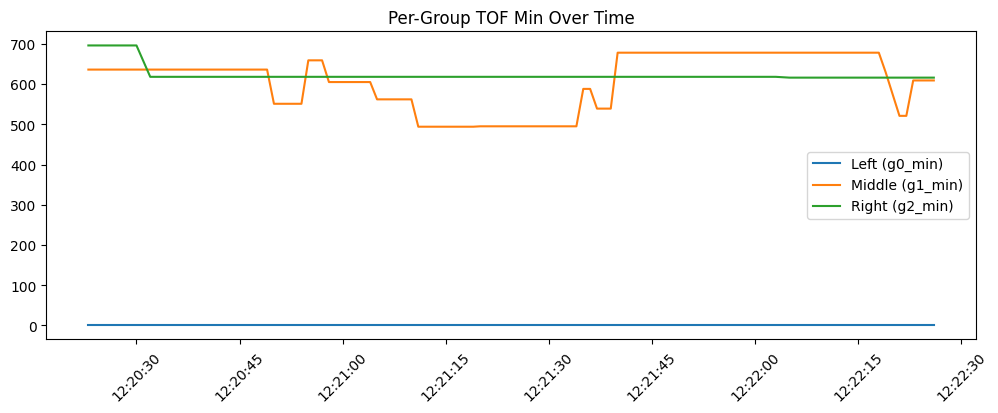

In [12]:
features_test = extract_features(df_test, tof_cols_test, tof_groups_test)

print(features_test.head())

plt.figure(figsize=(12,4))
plt.plot(features_test['timestamp'], features_test['g0_min'], label="Left (g0_min)")
plt.plot(features_test['timestamp'], features_test['g1_min'], label="Middle (g1_min)")
plt.plot(features_test['timestamp'], features_test['g2_min'], label="Right (g2_min)")
plt.legend()
plt.title("Per-Group TOF Min Over Time")
plt.xticks(rotation=45)
plt.show()


In [13]:
def parse_label_from_filename(fname, verbose=True):
    """
    Parses filenames of the form:
        case01_c1_L_moving.csv
        case04_c1c2_L-M_moving.csv
        case07_c1c2_L-M_stationary.csv
        case09_c2_M_moving.csv
        case10_empty.csv

    Returns label like:
        L_C1_MOVING
        L-M_C1C2_MOVING
        M_C2_MOVING
        NONE
    """
    original_fname = fname
    fname = fname.lower()

    if verbose:
        print(f"\n[parse_label] Parsing: {original_fname}")

    # ---------- Case: empty parking (no car) ----------
    if "empty" in fname or "noc" in fname:
        if verbose:
            print("  → Detected empty case")
        return "NONE"

    # ---------- Extract slot info ----------
    # This matches:
    #   _l
    #   _m
    #   _r
    #   _l-m
    #   _r-m
    slot_match = re.search(r"_(l|m|r)(-[lmr])?", fname)

    if not slot_match:
        if verbose:
            print("  → ERROR: Could not find slot configuration!")
        return "UNKNOWN"

    slot_config = slot_match.group(0).replace("_", "").upper()
    # examples: "L", "M", "R", "L-M", "R-M"

    if verbose:
        print(f"  → Slot config: {slot_config}")

    # ---------- Extract movement state ----------
    state = "MOVING"
    if "stationary" in fname:
        state = "STATIONARY"

    if verbose:
        print(f"  → State: {state}")

    # ---------- Extract car info ----------
    # priority: c1c2 > c2 > c1
    if "c1c2" in fname:
        car_info = "C1C2"
    elif "c2" in fname:
        car_info = "C2"
    else:
        car_info = "C1"

    if verbose:
        print(f"  → Car info: {car_info}")

    # ---------- Final label ----------
    label = f"{slot_config}_{car_info}_{state}"

    if verbose:
        print(f"  → Final label: {label}")

    return label


In [14]:
def summarize_and_plot(df, tof_cols, groups, out_prefix, verbose=True):
    """
    Creates diagnostic plots:
    - TOF group mean over time
    - TOF group min over time
    - Magnetometer norm over time

    Saves PNG files using out_prefix.
    """

    if verbose:
        print(f"[summarize_and_plot] Saving diagnostics for: {out_prefix}")

    # --------------------------
    # 1. TOF GROUP MEAN PLOT
    # --------------------------
    plt.figure(figsize=(12,4))
    for i, g in enumerate(groups):
        plt.plot(df['timestamp'], df[g].mean(axis=1), label=f"Group {i} mean")
    plt.legend()
    plt.title("TOF Group Mean Over Time")
    plt.xlabel("Time")
    plt.ylabel("Distance (mm)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(out_prefix + "_tof_group_mean.png", dpi=150)
    plt.close()

    # --------------------------
    # 2. TOF GROUP MIN PLOT
    # --------------------------
    plt.figure(figsize=(12,4))
    for i, g in enumerate(groups):
        plt.plot(df['timestamp'], df[g].min(axis=1), label=f"Group {i} min")
    plt.legend()
    plt.title("TOF Group MIN Over Time")
    plt.xlabel("Time")
    plt.ylabel("Distance (mm)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(out_prefix + "_tof_group_min.png", dpi=150)
    plt.close()

    # --------------------------
    # 3. MAGNETOMETER NORM PLOT
    # --------------------------
    mag_cols = [c for c in df.columns if c.lower().startswith(('mx','my','mz'))]
    if len(mag_cols) >= 3:
        mag_cols = sorted(mag_cols)
        mx, my, mz = df[mag_cols[0]], df[mag_cols[1]], df[mag_cols[2]]
        mag_norm = np.sqrt(mx**2 + my**2 + mz**2)

        plt.figure(figsize=(12,4))
        plt.plot(df['timestamp'], mag_norm, label="mag_norm", color="purple")
        plt.legend()
        plt.title("Magnetometer Norm Over Time")
        plt.xlabel("Time")
        plt.ylabel("Magnetic Field (uT)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(out_prefix + "_mag_norm.png", dpi=150)
        plt.close()

    else:
        if verbose:
            print("[summarize_and_plot] No magnetometer columns found. Skipping mag plot.")

    if verbose:
        print(f"[summarize_and_plot] Saved: {out_prefix}_*.png")


In [15]:
def plot_mag(df, title):
    """
    Plots magnetometer axes.

    Works with both:
    - raw CSV columns: mx_uT, my_uT, mz_uT
    - feature columns: mag_x, mag_y, mag_z
    """

    # ---- Detect columns ----
    raw_cols = [c for c in df.columns if c.lower().startswith(("mx", "my", "mz"))]
    feat_cols = ["mag_x", "mag_y", "mag_z"]

    if all(c in df.columns for c in feat_cols):
        # feature dataframe case
        cols = feat_cols
        label_map = {"mag_x": "mx", "mag_y": "my", "mag_z": "mz"}
        if True:
            print(f"[plot_mag] Using feature magnetometer columns: {cols}")
    elif len(raw_cols) >= 3:
        # raw CSV case
        raw_cols = sorted(raw_cols)  # ensures x,y,z order
        cols = raw_cols[:3]
        label_map = {cols[0]: "mx", cols[1]: "my", cols[2]: "mz"}
        print(f"[plot_mag] Using raw magnetometer columns: {cols}")
    else:
        print("[plot_mag] No magnetometer columns found. Skipping plot.")
        return

    # ---- Plot ----
    plt.figure(figsize=(12,4))
    for c in cols:
        plt.plot(df["timestamp"], df[c], label=label_map.get(c, c))

    plt.legend()
    plt.title(f"Magnetometer Axes - {title}")
    plt.xlabel("Time")
    plt.ylabel("Magnetic Field (uT)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [16]:
def plot_tof_groups(df, tof_groups, title, use_timestamp=True):
    """
    Plots TOF group mean signals over time.
    Automatically handles:
    - timestamp or index x-axis
    - empty groups
    - multi-sensor TOF groups
    """

    # Choose X-axis
    if use_timestamp and 'timestamp' in df.columns:
        x = df['timestamp']
        x_label = "Time"
    else:
        x = np.arange(len(df))
        x_label = "Frame"

    plt.figure(figsize=(12,4))

    for i, grp in enumerate(tof_groups):
        if len(grp) == 0:
            print(f"[plot_tof_groups] WARNING: Group {i} is empty. Skipping.")
            continue

        # mean of that group across sensors
        y = df[grp].mean(axis=1)

        plt.plot(x, y, label=f"Group {i} mean")

    plt.legend()
    plt.title(f"TOF Group Means - {title}")
    plt.xlabel(x_label)
    plt.ylabel("Distance (mm)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [17]:
def plot_tof_groups_min(df, tof_groups, title, use_timestamp=True):
    """
    Plots TOF group MIN values over time (best for detecting car presence).
    """
    if use_timestamp and 'timestamp' in df.columns:
        x = df['timestamp']
        x_label = "Time"
    else:
        x = np.arange(len(df))
        x_label = "Frame"

    plt.figure(figsize=(12,4))

    for i, grp in enumerate(tof_groups):
        if len(grp) == 0:
            print(f"[plot_tof_groups_min] WARNING: Group {i} empty. Skipping.")
            continue

        y = df[grp].min(axis=1)
        plt.plot(x, y, label=f"Group {i} min")

    plt.legend()
    plt.title(f"TOF Group MIN - {title}")
    plt.xlabel(x_label)
    plt.ylabel("Distance (mm)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [18]:
def plot_feature_hists(feats, title):
    """
    Plots histograms of important numeric features to help visually choose thresholds.
    """

    # Select meaningful numeric columns
    cols = [c for c in feats.columns
            if any(x in c for x in ['_min', '_mean', 'mag_norm', 'tof_'])
            and feats[c].dtype != 'O']

    cols = cols[:6]  # limit to avoid clutter

    if len(cols) == 0:
        print("[plot_feature_hists] No numeric feature columns found. Skipping.")
        return

    print(f"[plot_feature_hists] Plotting histograms for: {cols}")

    feats[cols].hist(bins=40, figsize=(12,6))
    plt.suptitle(f"Feature Histograms – {title}", fontsize=14)
    plt.tight_layout()
    plt.show()


In [19]:
import seaborn as sns

def plot_pair(feats, title):
    """
    Pairplot to inspect feature separability across labels.
    Automatically checks that required columns exist.
    """

    required = ['g0_min', 'g1_min', 'g2_min', 'mag_norm', 'label']

    missing = [c for c in required if c not in feats.columns]
    if missing:
        print(f"[plot_pair] Missing columns {missing}. Cannot create pairplot.")
        return

    # sample to keep seaborn fast
    sample = feats.sample(min(500, len(feats)), random_state=42)

    print("[plot_pair] Creating pairplot for columns:", required)

    sns.pairplot(sample[required], hue="label", diag_kind="kde", corner=True)
    plt.suptitle(f"Pairplot – {title}", y=1.02)
    plt.show()


In [20]:
def visualize_case(df, feats, tof_groups, fname):
    """
    Runs a full visualization suite for a single case.
    df     = raw dataframe
    feats  = extracted features
    tof_groups = clustered TOF groups from this case
    """

    title = fname.replace(".csv", "")

    print(f"\n====================================")
    print(f"   VISUALIZING CASE: {title}")
    print(f"====================================")

    # 1. Magnetometer
    print("[visualize_case] → Magnetometer plot")
    plot_mag(df, title)

    # 2. TOF groups (mean)
    print("[visualize_case] → TOF group MEAN plot")
    plot_tof_groups(df, tof_groups, title)

    # 3. TOF group MIN plot (extra important)
    print("[visualize_case] → TOF group MIN plot")
    plot_tof_groups_min(df, tof_groups, title)

    # 4. Feature distributions
    print("[visualize_case] → Feature histograms")
    plot_feature_hists(feats, title)

    # 5. Pairplot only for smaller datasets
    if len(feats) < 2000:
        print("[visualize_case] → Pairplot")
        plot_pair(feats, title)
    else:
        print("[visualize_case] Skipping pairplot (too many rows).")


In [21]:
import os, glob
import pandas as pd

def main(data_dir, out_file, visualize=False):
    print("\n====================================")
    print("      FEATURE EXTRACTION PIPELINE")
    print("====================================")
    print(f"[main] Data directory: {data_dir}")

    # ------------------------------------------------
    # STEP 1: Load all files
    # ------------------------------------------------
    files = sorted(glob.glob(os.path.join(data_dir, "*.csv")))
    if len(files) == 0:
        print("[main] ERROR: No CSV files found.")
        return

    print(f"[main] Found {len(files)} CSV files.")

    dfs = []
    all_tof_cols = None

    # Preload all data so we can cluster TOF globally
    for f in files:
        print(f"\n[main] Loading file: {os.path.basename(f)}")
        df = load_csv(f)
        dfs.append((f, df))

        tof_cols = find_tof_cols(df, verbose=False)

        if all_tof_cols is None:
            all_tof_cols = tof_cols
        else:
            # ensure consistency across files
            all_tof_cols = list(sorted(set(all_tof_cols).intersection(tof_cols),
                                       key=lambda c: int(re.search(r"\d+", c).group())))

    if len(all_tof_cols) == 0:
        print("[main] ERROR: No common TOF columns across all files.")
        return

    print(f"\n[main] Common TOF channels across all files: {len(all_tof_cols)} channels")
    print(all_tof_cols[:12], "...")

    # ------------------------------------------------
    # STEP 2: Cluster TOF groups ONCE across all data
    # ------------------------------------------------
    print("\n[main] Clustering TOF groups globally...")

    # Concat all TOF columns from all files for clustering stability
    concat_tof_df = pd.concat([df[all_tof_cols] for _, df in dfs], ignore_index=True)

    global_tof_groups = cluster_tof_channels(concat_tof_df, all_tof_cols, n_clusters=3)

    print("\n[main] Final global TOF groups:")
    for i, g in enumerate(global_tof_groups):
        print(f"  Group {i}: {len(g)} sensors (ex: {g[:6]})")

    # ------------------------------------------------
    # STEP 3: Extract features per file
    # ------------------------------------------------
    feat_list = []
    meta = []

    print("\n[main] Extracting features...")

    for f, df in dfs:
        fname = os.path.basename(f)
        print(f"\n[main] Processing {fname}")

        feats = extract_features(df, all_tof_cols, global_tof_groups)

        label = parse_label_from_filename(fname, verbose=False)
        feats["label"] = label
        feats["source_file"] = fname

        feat_list.append(feats)
        meta.append({"file": fname, "rows": len(df), "label": label})

        # Optional heavy visualization
        if visualize:
            visualize_case(df, feats, global_tof_groups, fname)

        # Save diagnostic plots
        summarize_and_plot(
            df,
            all_tof_cols,
            global_tof_groups,
            out_prefix=os.path.join(data_dir, fname.split(".")[0]),
            verbose=False
        )

    # ------------------------------------------------
    # STEP 4: Save final combined feature file
    # ------------------------------------------------
    allfeats = pd.concat(feat_list, ignore_index=True)
    allfeats.to_csv(out_file, index=False)

    print("\n====================================")
    print(f"[main] Wrote final features to: {out_file}")
    print("====================================")
    print(pd.DataFrame(meta))


In [22]:
main("data/", "features.csv", visualize=False)



      FEATURE EXTRACTION PIPELINE
[main] Data directory: data/
[main] Found 10 CSV files.

[main] Loading file: case01_c1_L_moving.csv
[load_csv] Loaded data/case01_c1_L_moving.csv
[load_csv] Shape: (100, 68)
[load_csv] Timestamp range: 2025-10-13 12:20:23 → 2025-10-13 12:22:26
[load_csv] Columns: ['timestamp', 'mx_uT', 'my_uT', 'mz_uT', 'd0_mm', 'd1_mm', 'd2_mm', 'd3_mm', 'd4_mm', 'd5_mm', 'd6_mm', 'd7_mm'] ...

[main] Loading file: case02_c1_M_moving.csv
[load_csv] Loaded data/case02_c1_M_moving.csv
[load_csv] Shape: (100, 68)
[load_csv] Timestamp range: 2025-10-13 12:13:21 → 2025-10-13 12:15:23
[load_csv] Columns: ['timestamp', 'mx_uT', 'my_uT', 'mz_uT', 'd0_mm', 'd1_mm', 'd2_mm', 'd3_mm', 'd4_mm', 'd5_mm', 'd6_mm', 'd7_mm'] ...

[main] Loading file: case03_c1_R_moving.csv
[load_csv] Loaded data/case03_c1_R_moving.csv
[load_csv] Shape: (100, 68)
[load_csv] Timestamp range: 2025-10-13 12:17:01 → 2025-10-13 12:19:03
[load_csv] Columns: ['timestamp', 'mx_uT', 'my_uT', 'mz_uT', 'd0_mm'